# Initial test with spectral signal of gene trees

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sys, subprocess, time, dendropy, os
import numpy as np
from sklearn import manifold, metrics, cluster, neighbors, decomposition, preprocessing

bindir="/home/leo/local/bin/"
localdir="/tmp/"

In [3]:
# distances are dups, loss, dcoal, spr, rf, hdist
def distance_signal (gtree, stree): 
    os.chdir(localdir)
    gtree.write(path="gene.tre", schema="nexus")
    stree.write(path="species.tre", schema="nexus")
    proc_run = subprocess.run(bindir + "gf_distsignal_genetree_sptree gene.tre species.tre", shell=True, 
                              stdout=subprocess.PIPE, universal_newlines=True)

    x = [[float(i) for i in line.split()] for line in proc_run.stdout.splitlines()]
    return np.array(x)

In [4]:
def add_trees (tree1, tree2, first):
    otre = tree1
    for i in range(first, len(tree2)):
        otre.append(tree2[i])
    return otre

def add_noise (tree, n_noise):
    os.chdir(localdir)
    tree.write(path="tmp2.tre", schema="nexus")
    proc_run = subprocess.run([bindir + "bmc2_addTreeNoise", "tmp2.tre", "0.9", "0.1", str(n_noise)],
                              stdout=subprocess.PIPE, universal_newlines=True)
    return dendropy.TreeList.get(path="noise.tre", schema="nexus")

In [78]:
def generate_trees (n_trees, n_spr, max_error, n_noise, n_leaves):
    os.chdir(localdir)
    proc_run = subprocess.run([bindir + "gf_generate_spr_trees", str(n_leaves), str(n_trees-1), str(n_spr)],
                              stdout=subprocess.PIPE, universal_newlines=True)
    with open("tmp.tre", "w") as trefile:
        print(proc_run.stdout, file=trefile)
    proc_run = subprocess.run([bindir + "bmc2_addTreeNoise", "tmp.tre", "0.9", str(max_error), str(n_noise)],
                              stdout=subprocess.PIPE, universal_newlines=True)
    return dendropy.TreeList.get(path="tmp.tre", schema="nexus"), dendropy.TreeList.get(path="noise.tre", schema="nexus")

In [79]:
def create_missing_leaves(tree, n_missing):
    tx_miss = np.random.permutation(tree.taxon_namespace)[:n_missing]
    for t in tree:
        t.prune_taxa(tx_miss)
    for tx in tx_miss:
        tree.taxon_namespace.remove_taxon(tx)

In [80]:
g_sample_size = 5
n_loci = 9  # actually one more than the number selected here since we have the first locus, initialized differently
st_skip = 5 # if st_skip == g_sample_size then it will not have the "true" gene trees
n_taxa_pruned = 2
n_leaves = 24

gt = [None] * (n_loci+1)
gt[0], st = generate_trees (g_sample_size,1,0.1, 10, n_leaves)
st = st[st_skip:]
create_missing_leaves(gt[0], n_taxa_pruned)
glabels = np.repeat(0,g_sample_size)
slabels = np.repeat(0.2,len(st))

for i in range(1,n_loci+1):
    gt[i],y = generate_trees (g_sample_size,1,0.1, 10, n_leaves)
    create_missing_leaves(gt[i], n_taxa_pruned)
    st = add_trees(st, y, st_skip)
    glabels = np.append(glabels,np.repeat(i, g_sample_size))
    slabels = np.append(slabels,np.repeat(i + 0.2, len(y) - st_skip))

In [81]:
signal = distance_signal(st, st)
for i in range(0,n_loci+1):
    s_i = distance_signal(gt[i], st)
    signal = np.append(signal, s_i, 0)
print (signal, signal.shape,len(slabels), len(glabels))

[[  0.   0.   0. ...,  18.  42.  94.]
 [  4.  12.   4. ...,  18.  42.  96.]
 [  4.  13.   5. ...,  16.  42.  95.]
 ..., 
 [ 12.  80.  56. ...,   6.  20.  19.]
 [ 11.  76.  54. ...,   5.  10.  10.]
 [ 12.  80.  56. ...,   4.   4.   4.]] (541, 2946) 491 50


In [82]:
transf=manifold.MDS(n_components=2).fit_transform(signal)

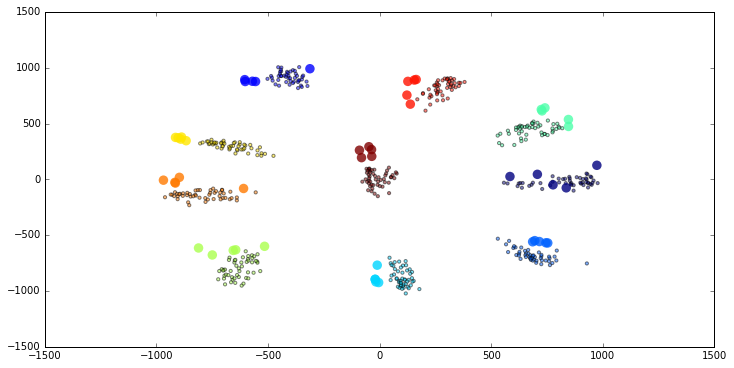

In [83]:
sps = len(slabels)
sl2 = slabels/10.2; gl2 = glabels/10.2
fig, axes = plt.subplots(1) ; fig.set_size_inches(12, 6)
axes.scatter(transf[:sps,1], transf[:sps,0], c=sl2, edgecolor="black", alpha=.5, s=10)
axes.scatter(transf[sps:,1], transf[sps:,0], c=gl2, edgecolor="none", alpha=.8, s=90)

### TODO:
- remove duplicates (in dendropy, since distsignal_genetree_sptree works with redundant set, not "distinct"
- simulate missing data and re-write distance_signal to work with missing data
- allow for 'smart' set of sptrees, besides 'random'
- functions should clean the localdir (once we are done with debugging)